In [68]:
# Mount Google Drive
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

# Mount your Google Drive
drive.mount('/content/drive')

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/Embedded_AI/dataset foglie'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
# Define paths for each class
sane_path = os.path.join(dataset_path, 'sane')
malate_path = os.path.join(dataset_path, 'malate')

# Check if paths exist
print("Checking dataset paths:")
print(f"Dataset folder exists: {os.path.exists(dataset_path)}")
print(f"Sane folder exists: {os.path.exists(sane_path)}")
print(f"Malate folder exists: {os.path.exists(malate_path)}")

Checking dataset paths:
Dataset folder exists: True
Sane folder exists: True
Malate folder exists: True


In [70]:
# Function to load images from a folder
def load_images_from_folder(folder_path, label):
    """
    Load all JPG images from a folder and return images with labels
    """
    images = []
    labels = []

    # Get all jpg files (case insensitive)
    jpg_files = glob.glob(os.path.join(folder_path, '*.jpg')) + \
                glob.glob(os.path.join(folder_path, '*.JPG')) + \
                glob.glob(os.path.join(folder_path, '*.jpeg')) + \
                glob.glob(os.path.join(folder_path, '*.JPEG'))

    print(f"Found {len(jpg_files)} images in {folder_path}")

    for img_path in jpg_files:
        try:
            # Load image using PIL
            img = Image.open(img_path)
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            # Convert to numpy array
            img_array = np.array(img)

            images.append(img_array)
            labels.append(label)

        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    return images, labels

In [71]:
def display_sample_images(images, labels, class_names=['sane', 'malate'], num_samples=4):
    """
    Display sample images from the dataset
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    # Show samples from each class
    for class_idx in range(2):
        class_images = [img for img, label in zip(images, labels) if label == class_idx]

        for i in range(min(num_samples, len(class_images))):
            ax = axes[class_idx, i]
            ax.imshow(class_images[i])
            ax.set_title(f'{class_names[class_idx]} - {i+1}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [72]:
# Load images from both folders
print("\nLoading images...")

# Load sane images (label 0)
sane_images, sane_labels = load_images_from_folder(sane_path, 0)

# Load malate images (label 1)
malate_images, malate_labels = load_images_from_folder(malate_path, 1)


Loading images...
Found 47 images in /content/drive/MyDrive/Embedded_AI/dataset foglie/sane
Found 50 images in /content/drive/MyDrive/Embedded_AI/dataset foglie/malate


In [73]:
all_images = sane_images + malate_images
all_labels = sane_labels + malate_labels

print(f"\nDataset Summary:")
print(f"Total sane images: {len(sane_images)}")
print(f"Total malate images: {len(malate_images)}")
print(f"Total images: {len(all_images)}")


Dataset Summary:
Total sane images: 47
Total malate images: 50
Total images: 97



Sample image shape: (240, 240, 3)


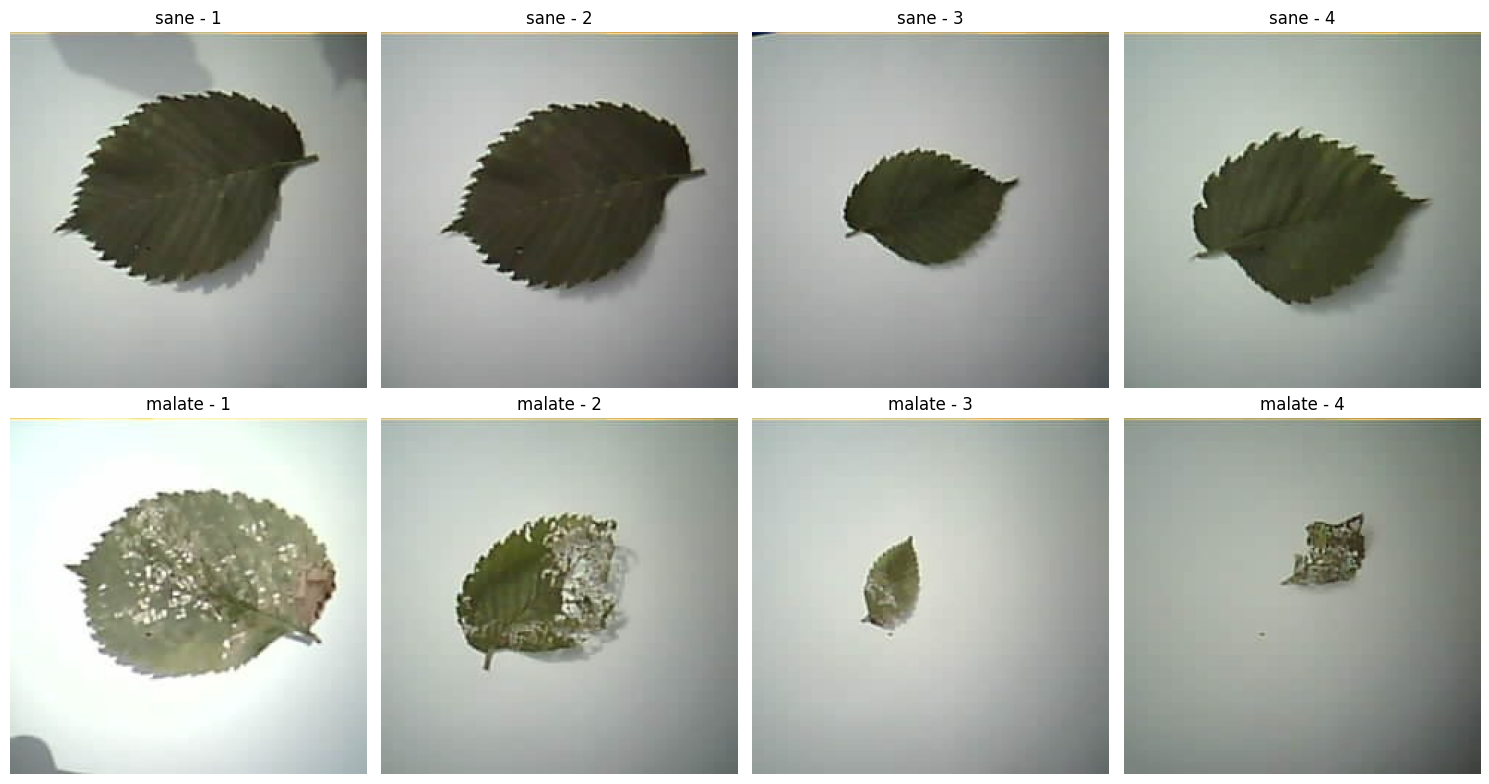

In [74]:
if len(all_images) > 0:
    print(f"\nSample image shape: {all_images[0].shape}")
    display_sample_images(all_images, all_labels)
else:
    print("No images found. Please check your folder paths.")

In [75]:
if len(all_images) > 0:
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)

    print(f"\nArray shapes:")
    print(f"Images array shape: {X.shape}")
    print(f"Labels array shape: {y.shape}")

    # Display class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution:")
    for class_idx, count in zip(unique, counts):
        class_name = 'sane' if class_idx == 0 else 'malate'
        print(f"{class_name}: {count} images")


Array shapes:
Images array shape: (97, 240, 240, 3)
Labels array shape: (97,)

Class distribution:
sane: 47 images
malate: 50 images


In [76]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from PIL import Image

In [77]:
# Define augmentation pipeline using Albumentations
transform = A.Compose([
    # Geometric transformations
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=90, p=0.7),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=40,
        p=0.9
    ),

    # Color and lighting augmentations
    A.RandomBrightnessContrast(
        brightness_limit=0.3,
        contrast_limit=0.5,
        p=0.7
    ),

    A.HueSaturationValue(
    hue_shift_limit=20,
    sat_shift_limit=30,
    val_shift_limit=20,
    p=0.8
    ),

    # Blur and distortion
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=0.5),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.2),
    ], p=0.7),


    # Perspective and distortion
    A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.3),
    A.GridDistortion(p=0.2),
])

/tmp/ipython-input-349728351.py:37: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.3),


In [78]:
def augment_dataset(images, labels, augmentations_per_image=3):
    """
    Apply augmentations to create an expanded dataset
    """
    augmented_images = []
    augmented_labels = []

    # Keep original images
    augmented_images.extend(images)
    augmented_labels.extend(labels)

    print(f"Applying {augmentations_per_image} augmentations per image...")

    for i, (image, label) in enumerate(zip(images, labels)):
        if i % 50 == 0:  # Progress indicator
            print(f"Processing image {i+1}/{len(images)}")

        for _ in range(augmentations_per_image):
            # Apply augmentation
            augmented = transform(image=image)
            augmented_image = augmented['image']

            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

In [79]:
# Function to visualize original vs augmented images
def show_augmentation_examples(original_images, labels, num_examples=3):
    """
    Show original images alongside their augmented versions
    """
    fig, axes = plt.subplots(num_examples, 4, figsize=(16, 4*num_examples))

    for i in range(num_examples):
        # Get a random image
        idx = random.randint(0, len(original_images)-1)
        original_img = original_images[idx]
        label = labels[idx]
        class_name = 'sane' if label == 0 else 'malate'

        # Show original
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f'Original - {class_name}')
        axes[i, 0].axis('off')

        # Show 3 augmented versions
        for j in range(1, 4):
            augmented = transform(image=original_img)
            axes[i, j].imshow(augmented['image'])
            axes[i, j].set_title(f'Augmented {j}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

Applying 3 augmentations per image...
Processing image 1/97
Processing image 51/97

Augmentation Examples:


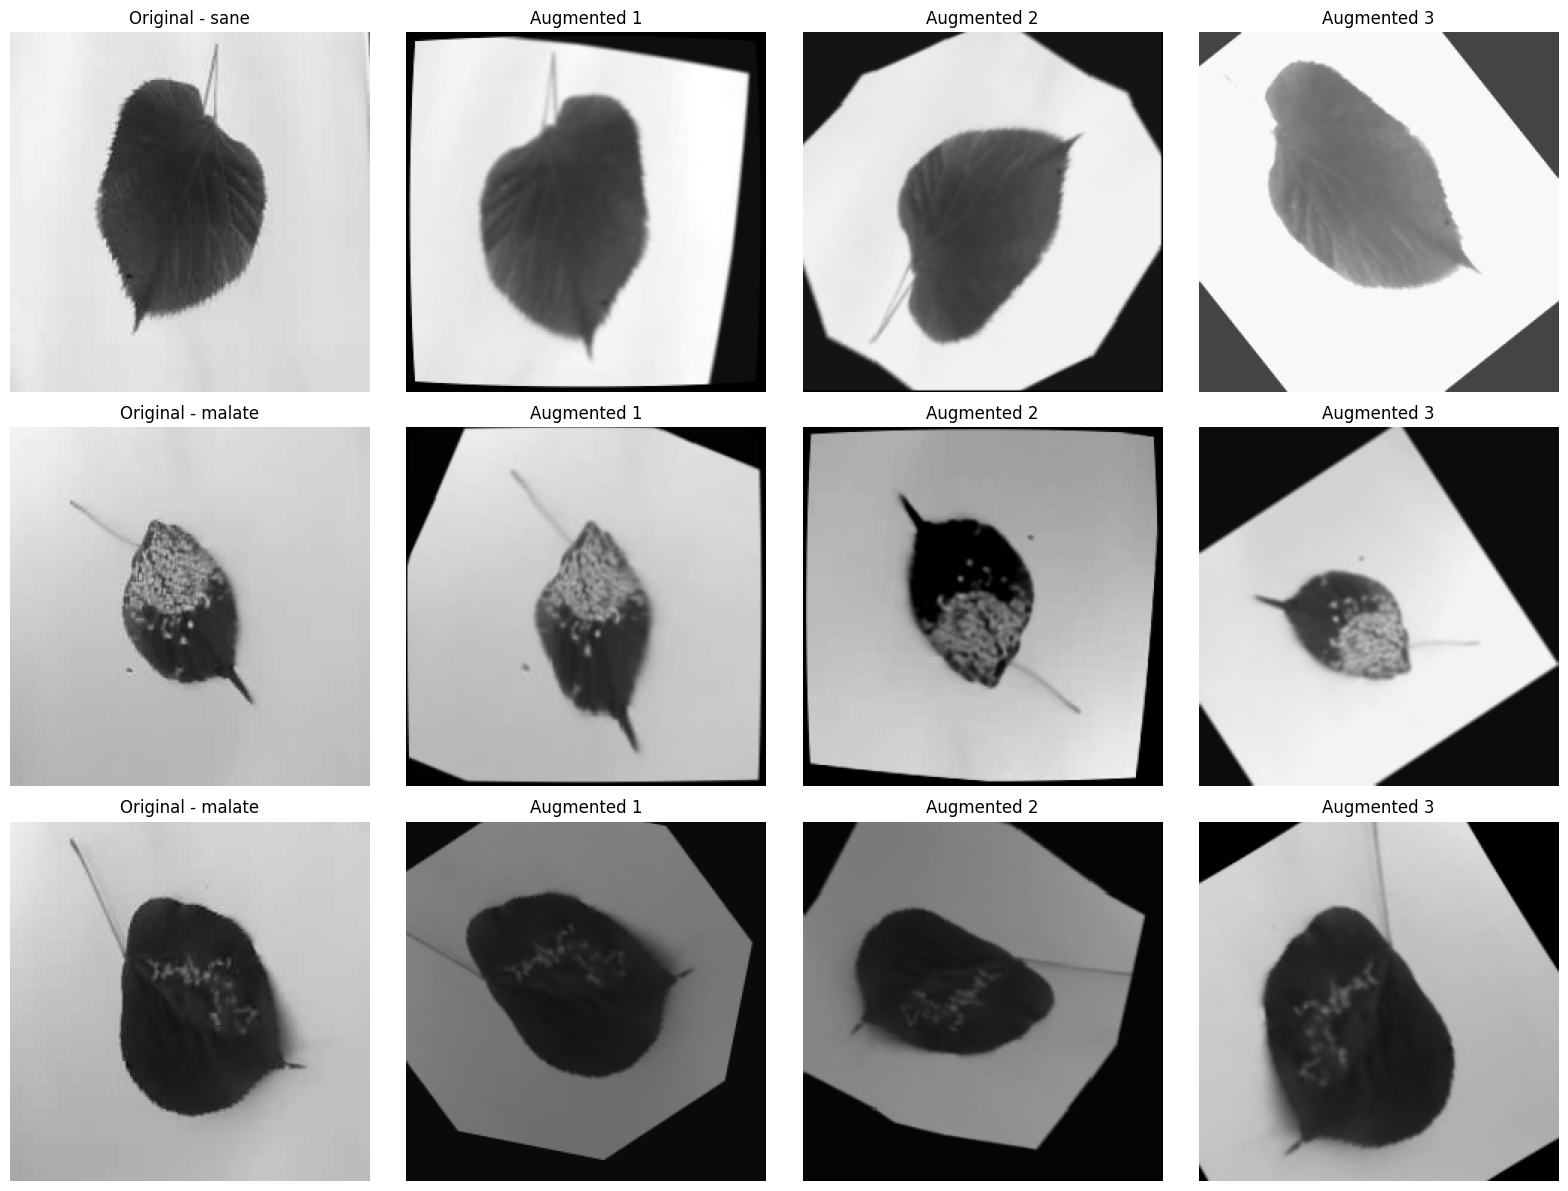

In [80]:
X_augmented, y_augmented = augment_dataset(X, y, augmentations_per_image=3)

# Show augmentation examples
print("\nAugmentation Examples:")
show_augmentation_examples(X, y)

In [81]:
print(f"\nAugmentation Results:")
print(f"Original dataset size: {len(X)}")
print(f"Augmented dataset size: {len(X_augmented)}")
print(f"Augmented images shape: {X_augmented.shape}")

# Check class balance after augmentation
unique, counts = np.unique(y_augmented, return_counts=True)
print(f"\nClass distribution after augmentation:")
for class_idx, count in zip(unique, counts):
    class_name = 'sane' if class_idx == 0 else 'malate'
    print(f"{class_name}: {count} images")


Augmentation Results:
Original dataset size: 97
Augmented dataset size: 388
Augmented images shape: (388, 240, 240, 3)

Class distribution after augmentation:
sane: 188 images
malate: 200 images


In [83]:
# Function to save augmented dataset (optional)
def save_augmented_dataset(images, labels, save_path):
    """
    Save augmented dataset back to Google Drive
    """
    os.makedirs(save_path, exist_ok=True)

    sane_save_path = os.path.join(save_path, 'sane_augmented')
    malate_save_path = os.path.join(save_path, 'malate_augmented')

    os.makedirs(sane_save_path, exist_ok=True)
    os.makedirs(malate_save_path, exist_ok=True)

    sane_count = 0
    malate_count = 0

    for img, label in zip(images, labels):
        if label == 0:  # sane
            img_pil = Image.fromarray(img)
            img_pil.save(os.path.join(sane_save_path, f'sane_aug_{sane_count:04d}.jpg'))
            sane_count += 1
        else:  # malate
            img_pil = Image.fromarray(img)
            img_pil.save(os.path.join(malate_save_path, f'malate_aug_{malate_count:04d}.jpg'))
            malate_count += 1

    print(f"Saved {sane_count} sane images and {malate_count} malate images")

# Uncomment the line below if you want to save the augmented dataset
save_augmented_dataset(X_augmented, y_augmented, '/content/drive/MyDrive/Embedded_AI/augmented_dataset')

Saved 188 sane images and 200 malate images
